In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.momdel_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [4]:
print(train.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
y = train['price']
del train['price']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

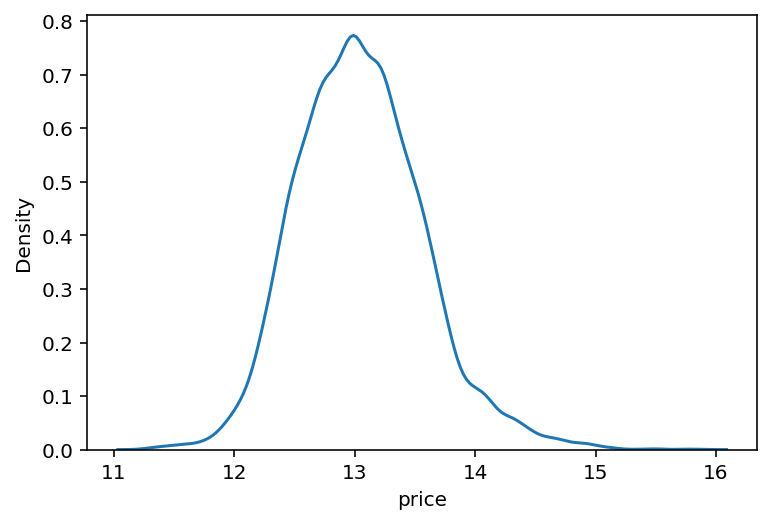

In [8]:
sns.kdeplot(y)
plt.show()

### 모델평가

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [10]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [11]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [13]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [15]:
get_scores(models, train, y)

RMSE
GradientBoostingRegressor  128360.196497
RandomForestRegressor      125487.071025
LGBMRegressor              111920.367359
XGBRegressor               110318.669566

### 학습 및 예측

In [86]:
model1_1 = LGBMRegressor(n_estimators=100,
     max_depth=15,
     learning_rate=0.025,
     num_iterations=1000,
     random_state=random_state)

model1_2 = LGBMRegressor(n_estimators=150,
     max_depth=10,
     learning_rate=0.05,
     num_iterations=1000,
     random_state=random_state)

model1_3 = LGBMRegressor(n_estimators=150,
     max_depth=10,
     learning_rate=0.075,
     num_iterations=1000,
     random_state=random_state)

model2 = GradientBoostingRegressor(max_depth=10, n_estimators=150, random_state=random_state)
model3 = XGBRegressor(max_depth=10, n_estimators=150, random_state=random_state)
model4 = RandomForestRegressor(max_depth=10, n_estimators=150, random_state=random_state)

model1_1.fit(train, y)
model1_2.fit(train, y)
model1_3.fit(train, y)

model2.fit(train, y)
model3.fit(train, y)
model4.fit(train, y)

prediction1_1 = model1_1.predict(test)
prediction1_2 = model1_2.predict(test)
prediction1_3 = model1_3.predict(test)

prediction2 = model2.predict(test)
prediction3 = model3.predict(test)
prediction4 = model4.predict(test)

In [87]:
prediction1_1 = np.expm1(prediction1_1)
prediction1_2 = np.expm1(prediction1_2)
prediction1_3 = np.expm1(prediction1_3)

prediction2 = np.expm1(prediction2)
prediction3 = np.expm1(prediction3)
prediction4 = np.expm1(prediction4)

prediction = 0.4*prediction1_1 + 0.3*prediction1_2 + 0.3*prediction1_3
#prediction = prediction1

In [88]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

id   price
0  15035  100000
1  15036  100000
2  15037  100000
3  15038  100000
4  15039  100000

In [89]:
submission['price'] = prediction
submission.head()

id         price
0  15035  4.917909e+05
1  15036  4.800060e+05
2  15037  1.346969e+06
3  15038  2.979417e+05
4  15039  3.289181e+05

In [91]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, '3_LGBMRegressor', '109815')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_3_LGBMRegressor_RMSLE_109815.csv


퍼블릭 스코어 : 109815.11966

### 하이퍼파라미터 튜닝

In [65]:
from sklearn.model_selection import GridSearchCV

In [66]:
model_1 = LGBMRegressor(random_state=random_state)
model_2 = GradientBoostingRegressor(random_state=random_state)
model_3 = XGBRegressor(random_state=random_state)
model_4 = RandomForestRegressor(random_state=random_state)

In [67]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.rename(columns={'RMSE': 'RMSLE'})
    results = results.sort_values('RMSLE')

    return results

### LGBMRegressor

In [85]:
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'learning_rate' : [0.025, 0.05, 0.1],
    'num_iterations' : [100, 1000]
    
}

model_1 = LGBMRegressor(random_state=random_state)
my_GridSearch(model_1, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   13.1s
[Parallel(n_jobs=5)]: Done 120 out of 120 | elapsed:   48.1s finished


learning_rate  max_depth  n_estimators  num_iterations     score     RMSLE
5           0.025         15           100            1000 -0.025830  0.160719
7           0.025         15           150            1000 -0.025830  0.160719
1           0.025         10           100            1000 -0.025882  0.160878
3           0.025         10           150            1000 -0.025882  0.160878
11          0.050         10           150            1000 -0.025930  0.161028
9           0.050         10           100            1000 -0.025930  0.161028
15          0.050         15           150            1000 -0.025983  0.161192
13          0.050         15           100            1000 -0.025983  0.161192
19          0.100         10           150            1000 -0.026739  0.163521
17          0.100         10           100            1000 -0.026739  0.163521
21          0.100         15           100            1000 -0.026958  0.164190
23          0.100         15           150            1000 -0.026958  0.164190
16          0.100         10           100             100 -0.027027  0.164399
18          0.100         10           150             100 -0.027027  0.164399
20          0.100         15           100             100 -0.027174  0.164845
22          0.100         15           150             100 -0.027174  0.164845
12          0.050         15           100             100 -0.029122  0.170650
14          0.050         15           150             100 -0.029122  0.170650
10          0.050         10           150             100 -0.029227  0.170960
8           0.050         10           100             100 -0.029227  0.170960
6           0.025         15           150             100 -0.037441  0.193496
4           0.025         15           100             100 -0.037441  0.193496
2           0.025         10           150             100 -0.037484  0.193609
0           0.025         10           100             100 -0.037484  0.193609

### GradientBoostingRegressor

In [81]:
my_GridSearch(model_2, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   46.0s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  1.5min finished


max_depth  n_estimators     score     RMSLE
5         10           150 -0.029408  0.171488
4         10           100 -0.029483  0.171706
3         10            50 -0.029899  0.172914
8         15           150 -0.038370  0.195882
7         15           100 -0.038375  0.195896
6         15            50 -0.038468  0.196133
2          1           150 -0.048459  0.220135
1          1           100 -0.055036  0.234597
0          1            50 -0.073253  0.270653

### XGBRegressor - 너무 오래걸려서 포기

In [82]:
my_GridSearch(model_3, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 14.2min
[Parallel(n_jobs=5)]: Done  32 tasks      | elapsed: 14.2min
[Parallel(n_jobs=5)]: Done  33 tasks      | elapsed: 14.2min
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed: 14.2min
[Parallel(n_jobs=5)]: Done  35 tasks      | elapsed: 14.2min
[Parallel(n_jobs=5)]: Done  36 tasks      | elapsed: 14.2min


KeyboardInterrupt: 

### RandomForestRegressor

In [83]:
my_GridSearch(model_4, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   31.4s
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:   58.4s finished


max_depth  n_estimators     score     RMSLE
8         15           150 -0.032000  0.178886
7         15           100 -0.032123  0.179229
6         15            50 -0.032467  0.180187
5         10           150 -0.035054  0.187227
4         10           100 -0.035232  0.187702
3         10            50 -0.035439  0.188252
2          1           150 -0.178968  0.423046
1          1           100 -0.179128  0.423235
0          1            50 -0.179746  0.423965